In [1]:
# loading packages and libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import coo_matrix

# Data Loading and Preprocessing

In [2]:
# reading the dataset into a pandas frame
# since we're using a .tsv file, needs to define the seperater
walmart_base_data = pd.read_csv('walmart.tsv', sep='\t')
walmart_base_data.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')

In [3]:
# removing unnecessary columns and printing the first 10 rows
data = walmart_base_data[['Uniq Id','Product Id', 'Product Rating', 'Product Reviews Count', 'Product Category', 'Product Brand', 'Product Name', 'Product Image Url', 'Product Description', 'Product Tags']].copy()
data.head(10)

,Uniq Id,Product Id,Product Rating,Product Reviews Count,Product Category,Product Brand,Product Name,Product Image Url,Product Description,Product Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,NaN,NaN,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,NaN,NaN,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,fddc4df45b35efd886794b261f730c51,03b5fb878a33eadff8b033419eab9669,NaN,NaN,Beauty > Makeup > Lip,Kokie Cosmetics,"Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,0990cf89a59ca6a0460349a3e4f51d42,ce3d761e57d6ccad80619297b5b1bcbc,NaN,131.0,Seasonal > Stock Up Essentials > Personal Care...,Gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"In 1971, Gillette introduced the Trac II razor...","Gillette TRAC II Plus Razor Blade Refills, Fit..."
5,262bcd1c9a561f6c6ad12bfdddc0d99e,7569141059e839b828a5bd3887243c1a,4.6,52.0,Beauty > Hair Care > Hair Care Brands > Old Sp...,Old Spice,Old Spice Artisan Styling High Hold Matte Fini...,https://i5.walmartimages.com/asr/73214b95-72ce...,Old Spice Artisan Molding Clay is a Mens Styli...,Old Spice Artisan Styling High Hold Matte Fini...
6,05224642381f73764e85a3382ee0ff61,b371dbac1c2d9457f61742c3c39bbdf3,4.3,10.0,Personal Care > Oral Care > Kids Oral Care,Colgate,"Colgate My First Baby and Toddler Toothpaste, ...",https://i5.walmartimages.com/asr/d28b16f4-1bd4...,Colgate My First Baby and Toddler Toothpaste i...,"Colgate My First Baby and Toddler Toothpaste, ..."
7,b6fb4b2b249da1f93d2f02a6dc62785d,0ae9899c34f93097275ecea00978c67e,NaN,NaN,Beauty > Makeup > Nails,BMC,BMC Bright and Loud Cream Gel Lacquer Polish S...,https://i5.walmartimages.com/asr/93f8bbf3-2dfd...,"Lights, Sick Beats, and Epic Gel Polish! We pr...",BMC Bright and Loud Cream Gel Lacquer Polish S...
8,507bc2f72d878d3fe76ca1557f229215,1007940052235879400000002000000000067565785US,5.0,1.0,Beauty > Hair Care > Hair Care Brands > Suave,Suave,Suave Extra Hold 7 Shaping Mousse 9 oz (Pack o...,https://i5.walmartimages.com/asr/05f5ba16-335d...,Free Shipping Pack of 6 Pack of 6 for the UPC:...,Suave Extra Hold 7 Shaping Mousse 9 oz (Pack o...
9,32f417078c38d85337779bb999c37e8b,1030521004419479400000002000000000067944214US,NaN,950.0,Health > Lip Care > Vaseline,Vaseline,(3 pack) Vaseline Lip Therapy Tinted Lip Balm ...,https://i5.walmartimages.com/asr/6fced36e-5459...,Vaseline Lip Therapy Lip Balm Mini Rosy is cli...,(3 pack) Vaseline Lip Therapy Tinted Lip Balm ...


In [4]:
# dataset shape
data.shape

(5000, 10)

In [5]:
# summarizing the missing values per column
data.isna().sum()

Uniq Id                     0
Product Id                  0
Product Rating           2806
Product Reviews Count    1654
Product Category           10
Product Brand              13
Product Name                0
Product Image Url           0
Product Description      1127
Product Tags                0
dtype: int64

In [6]:
# treating missing values with default values

# Product Rating --> 0
data.loc[:, 'Product Rating'] = data['Product Rating'].fillna(0)

# Product Reviews Count --> 0
data.loc[:, 'Product Reviews Count'] = data['Product Reviews Count'].fillna(0)

# Product Category --> ''
data.loc[:, 'Product Category'] = data['Product Category'].fillna('')

# Product Brand --> ''
data.loc[:, 'Product Brand'] = data['Product Brand'].fillna('')

# Product Description --> ''
data.loc[:, 'Product Description'] = data['Product Description'].fillna('')

In [7]:
# ensuring missing values are handled
data.isna().sum()

Uniq Id                  0
Product Id               0
Product Rating           0
Product Reviews Count    0
Product Category         0
Product Brand            0
Product Name             0
Product Image Url        0
Product Description      0
Product Tags             0
dtype: int64

In [8]:
# checking for duplicated values
data.duplicated().sum()

0

In [9]:
# remapping column labels with shorter lables
column_name_mapping = {
    'Uniq Id': 'Id',
    'Product Id': 'ProdId',
    'Product Rating': 'Rating',
    'Product Reviews Count': 'Reviews',
    'Product Category': 'Category',
    'Product Brand': 'Brand',
    'Product Name': 'Name',
    'Product Image Url': 'ImgUrl',
    'Product Description': 'Description',
    'Product Tags': 'Tags'
}

# rename the columns using the mapping
data.rename(columns=column_name_mapping, inplace=True)

In [10]:
# Extract digits from 'Id' and 'ProdId', convert to float

data['Id'] = data['Id'].str.extract(r'(\d+)').astype(float)
data['ProdId'] = data['ProdId'].str.extract(r'(\d+)').astype(float)

# Exploritory Data Analysis

In [11]:
# making a copy of the preprocessed data
df_proc = data.copy()

In [12]:
# unique values
num_users = df_proc['Id'].nunique()
num_item = df_proc['ProdId'].nunique()
num_ratings = df_proc['Rating'].nunique()
print(f'Number of unique users: ', num_users)
print(f'Number of unique products: ', num_item)
print(f'Number of unique ratings: ', num_ratings)

Number of unique users:  1721
Number of unique products:  1697
Number of unique ratings:  36


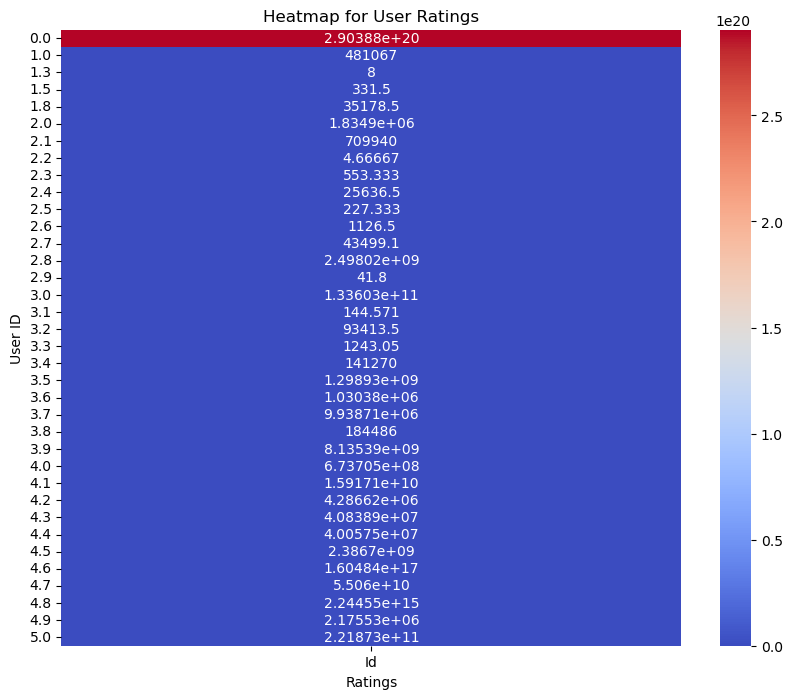

In [13]:
# pivot the dataframe to create a heatmap
heatmap_data = df_proc.pivot_table('Id', 'Rating')

# display the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='coolwarm', cbar=True)
plt.title('Heatmap for User Ratings')
plt.xlabel('Ratings')
plt.ylabel('User ID')
plt.show()

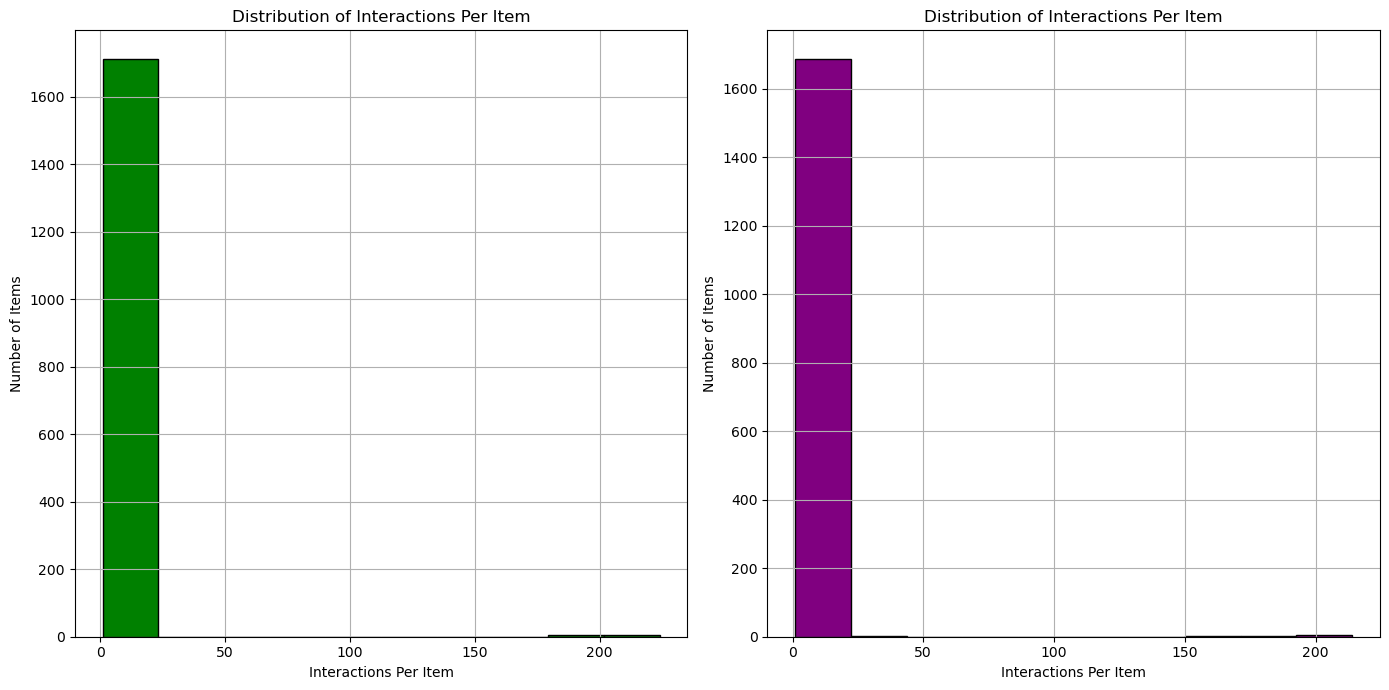

In [14]:
# distribution of user interactions

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
df_proc['Id'].value_counts().hist(bins=10, edgecolor='k', color='green')
plt.xlabel('Interactions Per Item')
plt.ylabel('Number of Items')
plt.title('Distribution of Interactions Per Item')

plt.subplot(1, 2, 2)
df_proc['ProdId'].value_counts().hist(bins=10, edgecolor='k', color='purple')
plt.xlabel('Interactions Per Item')
plt.ylabel('Number of Items')
plt.title('Distribution of Interactions Per Item')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Most Popular Items')

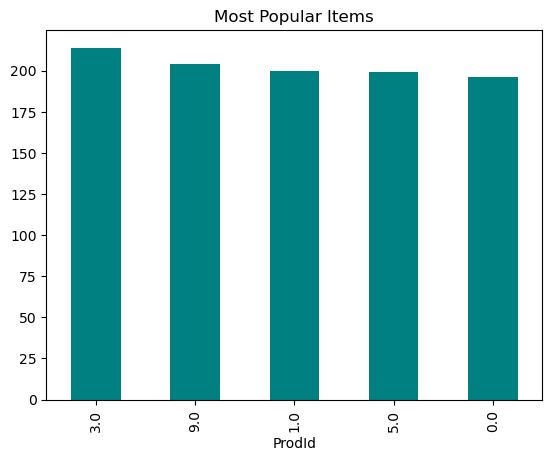

In [15]:
# most popular items
pop_items = df_proc['ProdId'].value_counts().head()
pop_items.plot(kind='bar', color='teal')
plt.title('Most Popular Items')

<Axes: xlabel='Rating'>

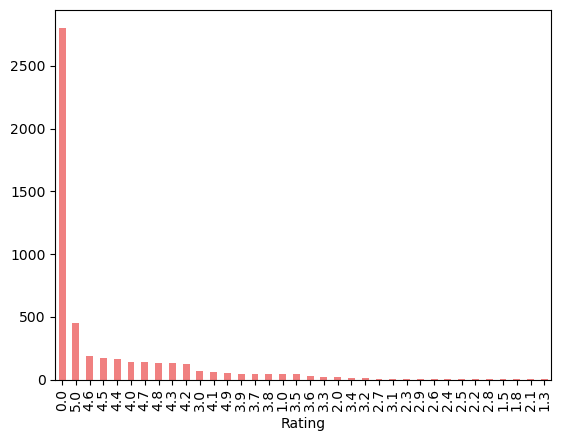

In [16]:
# most rated counts
df_proc['Rating'].value_counts().plot(kind='bar', color='lightcoral')

# NLP

In [17]:
# using spacy to extract tags
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm')

def extract_tags(text):
    doc = nlp(text.lower())
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
    return ', '.join(tags)

columns_to_extract_tags = ['Category', 'Brand', 'Description']

for column in columns_to_extract_tags:
    df_proc[column] = df_proc[column].apply(extract_tags)

In [18]:
# creating a new tags column based on category, brand, and description column data
df_proc['Tags'] = df_proc[columns_to_extract_tags].apply(lambda row: ', '.join(row), axis=1)

In [19]:
# saving the data frame to a csv file
df_proc.to_csv('data.csv')

# Rating-Based Recommendation System

In [33]:
# generating average ratings
average_ratings = df_proc.groupby(['Name', 'Reviews', 'Brand', 'ImgUrl'])['Rating'].mean().reset_index()

In [34]:
# generating top rated items
top_rated_items = average_ratings.sort_values(by='Rating', ascending=False)

In [37]:
# generating a dataframe based on ratings
rating_based_recommendation = top_rated_items.head(10)

In [41]:
print("Rating Base Recommendation System: (Trending Products)")

# Converting rating and reviews column types to int
rating_based_recommendation.loc[:, 'Rating'] = rating_based_recommendation['Rating'].astype(int)
rating_based_recommendation.loc[:, 'Reviews'] = rating_based_recommendation['Reviews'].astype(int)

# Print the DataFrame
print(rating_based_recommendation[['Name','Rating','Reviews','Brand','ImgUrl']])

Rating Base Recommendation System: (Trending Products)
                                                   Name  Rating  Reviews  \
1686  Electric Shaver, Triple Shaving Time Electric ...     5.0      4.0   
526                 Alaffia Body Lotion, Vanilla, 32 Oz     5.0      2.0   
2053  Gold Bond Ultimate Ultimate Healing Lotion, Al...     5.0      2.0   
4716  Versace Man Eau Fraiche Eau De Toilette Spray,...     5.0     24.0   
2058  Goldwell StyleSign 1 Flat Marvel Straightening...     5.0      2.0   
3842  Red Devil 0322 Steel Wool # 00 Very Fine, 8 Pa...     5.0      1.0   
510   Air Wick Plug in Starter Kit, Warmer + 1 Refil...     5.0      1.0   
3841  Recovery Complex Anti-Frizz Shine Serum by Bai...     5.0      4.0   
2687  Long Aid Extra Dry Formula Curl Activator Gel ...     5.0     12.0   
2062  Good Sense 60-Day Air Care System, Citrus, 2 o...     5.0      1.0   

                Brand                                             ImgUrl  
1686           moosoo  https://i5

# Content-Based Recommendation System

In [124]:
def get_content_based_recs(datax, item, top_count):
    # check if the item name exists in the data
    if item not in datax['Name'].values:
        print(f"Item '{item}' not found in the data.")
        return pd.DataFrame()

    # create a TF-IDF vectorizer for item descriptions
    vectorizer = TfidfVectorizer(stop_words='english')

    # apply TF-IDF vectorization to item descriptions
    X = vectorizer.fit_transform(datax['Tags'])

    # calculating cosine similarities
    cs = cosine_similarity(X, X)

    # find the index of the item
    item_index = datax[datax['Name'] == item].index[0]

    # calculate the cosine similarity for the item using the correct item_index
    similar_items = list(enumerate(cs[item_index]))

    # sort similar items by similarity score in descending order
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

    # retrieve the top N most similar items (excluding the item itself)
    top_similar_items = similar_items[1: top_count+1]

    # retrieve the indices of the top similar items
    recommended_items_indices = [x[0] for x in top_similar_items]

    # retrieve the details of the top similar items
    recommended_items_details = datax.iloc[recommended_items_indices][['Name', 'Reviews', 'Brand', 'ImgUrl', 'Rating']]

    return recommended_items_details

In [125]:
# example
item_name = 'Kokie Professional Matte Lipstick, Hot Berry, 0.14 fl oz'
content_based_recs = get_content_based_recs(df_proc, item_name, 8)
content_based_recs

,Name,Reviews,Brand,ImgUrl,Rating
3406,"Kokie Professional Matte Lipstick, Firecracker...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/8312221b-ed22...,0.0
546,"Kokie Professional Matte Lipstick, Kiss Me, 0....",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/27dd82a2-2b9c...,0.0
2406,"L.A. Colors Matte Lipstick, Tender Matte",3.0,colors,https://i5.walmartimages.com/asr/271264fb-e8c3...,3.7
4050,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/fdd7498c-319f...,3.4
4084,e.l.f. Mad for Matte 4 Piece Lip Color Set,0.0,cosmetics,https://i5.walmartimages.com/asr/e2d30304-edc9...,0.0
1559,"LOreal Paris Colour Riche Matte Lip Liner, Mat...",495.0,paris,https://i5.walmartimages.com/asr/baf97085-7231...,4.4
2873,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.4
3023,Be Matte Lipstick - Pink,2.0,"city, color",https://i5.walmartimages.com/asr/4425a13e-085f...,3.0


# Collaborative Filtering

In [126]:
def get_collborative_filtering_recs(datax, target_user_id, top_count):
    # create user item matrix
    user_item_matrix = datax.pivot_table(index='Id', columns='ProdId', values='Rating', aggfunc='mean').fillna(0).astype(int)

    # calculate the user similarity matrix using cosine similarity
    user_sim = cosine_similarity(user_item_matrix)

    # find the index of the target user in the matrix
    target_user_index = user_item_matrix.index.get_loc(target_user_id)

    # get the similarity of the target user in the matrix
    user_sims = user_sim[target_user_index]

    # sort the users by similarity in descending order (excluding the target user)
    similar_user_indices = user_sims.argsort()[::-1][1:]

    # generate recs based on similar users
    rec_items = []

    for user_index in similar_user_indices:
        # get the items rated by similar user but not by the target user
        rated_by_similar_user = user_item_matrix.iloc[user_index]
        not_rated_by_target_user = (rated_by_similar_user==0) & (user_item_matrix.iloc[target_user_index]==0)

        # extract the item ids of recommended items
        rec_items.extend(user_item_matrix.columns[not_rated_by_target_user][:top_count])

    # get the details of recommended items
    rec_items_details = df_proc[df_proc['ProdId'].isin(rec_items)][['Name', 'Reviews', 'Brand', 'ImgUrl', 'Rating']]

    return rec_items_details

In [127]:
# example
target_user_id = 4
top_count = 5
collaborative_filtering_rec = get_collborative_filtering_recs(df_proc, target_user_id, top_count)
print(f'Top {top_count} recommendations for User {target_user_id}:')
collaborative_filtering_rec

Top 5 recommendations for User 4:


,Name,Reviews,Brand,ImgUrl,Rating
15,Clairol Natural Instincts Demi-Permanent Hair ...,2935.0,clairol,https://i5.walmartimages.com/asr/00a6e54a-e431...,3.7
33,"DenTek Kids Fun Flossers, Removes Food & Plaqu...",3.0,dentek,https://i5.walmartimages.com/asr/de6e52eb-6e18...,0.0
61,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,covergirl,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.3
64,Neutrogena SkinClearing Oil-Free Liquid Founda...,741.0,neutrogena,https://i5.walmartimages.com/asr/fd4d78d8-310a...,4.2
69,Design Essentials Natural Coconut & Monoi Curl...,1.0,"design, essentials",https://i5.walmartimages.com/asr/ff2dba1d-0c02...,5.0
...,...,...,...,...,...
4964,"TENA Regular Absorbency Day Pad, Blue-Pack of 46",0.0,"sca, personal, care",https://i5.walmartimages.com/asr/74750306-8afd...,0.0
4983,Covidien Simplicity Underpad - 7136CS - 23&quo...,0.0,covidien,https://i5.walmartimages.com/asr/2b5ce91e-7b16...,0.0
4990,2 Pack - Crest 3D White Brilliance Fluoride An...,43.0,crest,https://i5.walmartimages.com/asr/5758fbaf-5515...,4.7
4996,Garnier Nutrisse Nourishing Hair Color Creme (...,7484.0,garnier,https://i5.walmartimages.com/asr/24d7a837-51f8...,3.9


# Hybrid Recommendations

In [128]:
# hybrid recommedations (combine content-based and collaborative filtering)

def get_hybrid_recs(datax, target_user_id, item_name, top_count):
    # get content_based_recommendations
    content_based_rec = get_content_based_recs(datax, item_name, top_count)

    # get collaborative filtering recommendations
    collaborative_filtering_rec = get_collborative_filtering_recs(datax, target_user_id, top_count)

    # merge and remove duplicate recommendations
    hybrid_rec = pd.concat([content_based_rec, collaborative_filtering_rec]).drop_duplicates()

    return hybrid_rec.head(top_count)

In [129]:
# example
target_user_id = 5
top_count = 10
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
hybrid_rec = get_hybrid_recs(df_proc, target_user_id, item_name, top_count)
print(f'Top {top_count} Hybrid Recommendations for User {target_user_id} and Item {item_name}:')
hybrid_rec

Top 10 Hybrid Recommendations for User 5 and Item OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath:


,Name,Reviews,Brand,ImgUrl,Rating
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,0.0
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,0.0
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,0.0
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,0.0
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,0.0
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.0
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0
886,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,0.0,opi,https://i5.walmartimages.com/asr/98b4194c-e026...,0.0
1042,"OPI GelColor Gel Nail Polish, Dulce De Leche, ...",1.0,opi,https://i5.walmartimages.com/asr/c1b2c370-b2d2...,0.0
